In [1]:
%pip install --upgrade tensorflow scikeras scikit-learn

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample
import joblib
import json



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [ ]:

file_path = "all_data.csv"  
data = pd.read_csv(file_path)


data['Label'] = data['Label'].replace({
    'Web Attack - Brute Force': 'Web Attack',
    'Web Attack - XSS': 'Web Attack',
    'Web Attack - Sql Injection': 'Web Attack'
})


rare_threshold = 60
class_distribution = data['Label'].value_counts()
rare_classes = class_distribution[class_distribution < rare_threshold].index
data['Label'] = data['Label'].apply(lambda x: 'Rare Events' if x in rare_classes else x)


X = data.drop(columns=['Label', 'Timestamp'], errors='ignore').select_dtypes(include=['number'])
y = data['Label']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


print("\nDistribuția claselor în setul de antrenament (înainte de SMOTE):")
print(Counter(y_train))


C:\Users\William\AppData\Local\Temp\ipykernel_50368\2894080513.py:3: DtypeWarning: Columns (84) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)



Distribuția claselor în setul de antrenament (înainte de SMOTE):
Counter({'BENIGN': 1651502, 'DoS Hulk': 161751, 'PortScan': 111251, 'DDoS': 29285, 'DoS GoldenEye': 7205, 'FTP-Patator': 5557, 'SSH-Patator': 4128, 'DoS slowloris': 4057, 'DoS Slowhttptest': 3849, 'Web Attack': 1526, 'Bot': 1376, 'Rare Events': 33})


In [ ]:

original_counts = pd.Series(y_train).value_counts()
print("Distribuția claselor înainte de SMOTE:", original_counts)


moderate_classes = original_counts[(original_counts >= 1_000) & (original_counts < 100_000)].index
rare_classes = original_counts[original_counts < 1_000].index


smote = SMOTE(
    sampling_strategy={label: int(count * 1.5) for label, count in original_counts.items() if label in moderate_classes},
    random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Oversampling pentru clasele rare (marim de 3 ori)
for label in rare_classes:
    class_data = X_train_smote[y_train_smote == label]
    class_labels = y_train_smote[y_train_smote == label]

    oversampled_data = resample(
        class_data,
        replace=True,
        n_samples=len(class_data) * 3,
        random_state=42
    )
    oversampled_labels = [label] * len(oversampled_data)

    X_train_smote = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame(oversampled_data)])
    y_train_smote = pd.concat([pd.Series(y_train_smote), pd.Series(oversampled_labels)])


balanced_counts = Counter(y_train_smote)
print("Distribuția claselor după SMOTE:", balanced_counts)


Distribuția claselor înainte de SMOTE: Label
BENIGN              1651502
DoS Hulk             161751
PortScan             111251
DDoS                  29285
DoS GoldenEye          7205
FTP-Patator            5557
SSH-Patator            4128
DoS slowloris          4057
DoS Slowhttptest       3849
Web Attack             1526
Bot                    1376
Rare Events              33
Name: count, dtype: int64
Distribuția claselor după SMOTE: Counter({'BENIGN': 1651502, 'DoS Hulk': 161751, 'PortScan': 111251, 'DDoS': 43927, 'DoS GoldenEye': 10807, 'FTP-Patator': 8335, 'SSH-Patator': 6192, 'DoS slowloris': 6085, 'DoS Slowhttptest': 5773, 'Web Attack': 2289, 'Bot': 2064, 'Rare Events': 132})


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Transformarea etichetelor in format numeric si one-hot encoding
label_mapping = {label: idx for idx, label in enumerate(sorted(np.unique(y_train_smote)))}
y_train_numeric = np.array([label_mapping[label] for label in y_train_smote])
y_test_numeric = np.array([label_mapping[label] for label in y_test])

y_train_categorical = to_categorical(y_train_numeric)
y_test_categorical = to_categorical(y_test_numeric)


In [ ]:
def create_optimized_model(input_shape, num_classes):
    model = Sequential() #putem adauga straturi unul dupa altul in ordine

    # Stratul 1: Dense + BatchNorm + LeakyReLU + Dropout
    model.add(Dense(256, input_shape=(input_shape,), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))

    # Stratul 2: Dense + BatchNorm + LeakyReLU + Dropout
    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    # Stratul 3: Dense + BatchNorm + LeakyReLU
    model.add(Dense(64, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

    # Stratul final: Softmax pentru clasificare multi-clasa
    model.add(Dense(num_classes, activation='softmax')) #1 neuron pt fiecare clasa

    # Compilarea
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
import time

start_time = time.time()

# Callback pentru ajustarea ratei de invatare
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-5)

# Crearea si antrenarea modelului
optimized_model = create_optimized_model(input_shape=X_train_scaled.shape[1], num_classes=y_train_categorical.shape[1])
history_optimized = optimized_model.fit(
    X_train_scaled, y_train_categorical,
    validation_data=(X_test_scaled, y_test_categorical),
    epochs=30, # o trecere completă prin toate datele de antrenament.
    batch_size=128, #Dacă ai 12.800 de exemple → cu batch_size=128 → vei avea 100 batch-uri per epocă.
    verbose=2,
    callbacks=[lr_scheduler]
)


c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/30
15704/15704 - 47s - 3ms/step - accuracy: 0.9777 - loss: 0.0557 - val_accuracy: 0.9878 - val_loss: 0.0229 - learning_rate: 1.0000e-03
Epoch 2/30
15704/15704 - 43s - 3ms/step - accuracy: 0.9864 - loss: 0.0289 - val_accuracy: 0.9896 - val_loss: 0.0181 - learning_rate: 1.0000e-03
Epoch 3/30
15704/15704 - 43s - 3ms/step - accuracy: 0.9875 - loss: 0.0258 - val_accuracy: 0.9897 - val_loss: 0.0181 - learning_rate: 1.0000e-03
Epoch 4/30
15704/15704 - 43s - 3ms/step - accuracy: 0.9881 - loss: 0.0242 - val_accuracy: 0.9908 - val_loss: 0.0168 - learning_rate: 1.0000e-03
Epoch 5/30
15704/15704 - 43s - 3ms/step - accuracy: 0.9885 - loss: 0.0232 - val_accuracy: 0.9899 - val_loss: 0.0167 - learning_rate: 1.0000e-03
Epoch 6/30
15704/15704 - 43s - 3ms/step - accuracy: 0.9887 - loss: 0.0225 - val_accuracy: 0.9900 - val_loss: 0.0164 - learning_rate: 1.0000e-03
Epoch 7/30
15704/15704 - 47s - 3ms/step - accuracy: 0.9889 - loss: 0.0220 - val_accuracy: 0.9901 - val_loss: 0.0164 - learning_rate: 1.0

In [7]:
test_loss, test_acc = optimized_model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"\nAcuratețea modelului optimizat pe setul de test: {test_acc:.4f}")

end_time = time.time()
execution_time = end_time - start_time

print(f"Timpul de antrenare a modelului: {execution_time:.2f} secunde")



Acuratețea modelului optimizat pe setul de test: 0.9904
Timpul de antrenare a modelului: 1328.07 secunde


In [ ]:
from sklearn.metrics import classification_report


y_pred_probs = optimized_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# Transformarea etichetelor inapoi la nume de clase
y_test_labels = np.argmax(y_test_categorical, axis=1)
class_labels = list(label_mapping.keys())


print("\nRaport de clasificare pentru modelul optimizat:\n")
print(classification_report(y_test_labels, y_pred, target_names=class_labels))




# salvare model antrenat
optimized_model.save("dense_model.h5")
print("✅ Modelul Keras salvat ca dense_model.h5")

# 2. scaler
joblib.dump(scaler, "dense_scaler.pkl")
print("✅ Scalerul salvat ca dense_scaler.pkl")

# 3. mapping
joblib.dump(label_mapping, "dense_label_mapping.pkl")
print("✅ Mapping-ul etichetelor salvat ca dense_label_mapping.pkl")

# 4. features folosite
deep_features = list(X_train.columns)

joblib.dump(deep_features, "dense_features.pkl")
print("✅ Lista de features salvată ca dense_features.pkl")


with open("dense_features.txt", "w") as f:
    for feat in deep_features:
        f.write(f"{feat}\n")
print("✅ Lista de features salvată și ca dense_features.txt")



26539/26539 ━━━━━━━━━━━━━━━━━━━━ 18s 676us/step

Raport de clasificare pentru modelul optimizat:



                  precision    recall  f1-score   support

          BENIGN       1.00      0.99      0.99    707787
             Bot       0.99      0.99      0.99       590
            DDoS       0.61      1.00      0.76     12550
   DoS GoldenEye       1.00      0.99      0.99      3088
        DoS Hulk       1.00      1.00      1.00     69322
DoS Slowhttptest       0.99      0.99      0.99      1650
   DoS slowloris       0.99      0.99      0.99      1739
     FTP-Patator       1.00      1.00      1.00      2381
        PortScan       1.00      1.00      1.00     47679
     Rare Events       0.61      0.79      0.69        14
     SSH-Patator       1.00      1.00      1.00      1769
      Web Attack       0.99      1.00      1.00       654

        accuracy                           0.99    849223
       macro avg       0.93      0.98      0.95    849223
    weighted avg       0.99      0.99      0.99    849223

✅ Modelul Keras salvat ca dense_model.h5
✅ Scalerul salvat ca dense_s

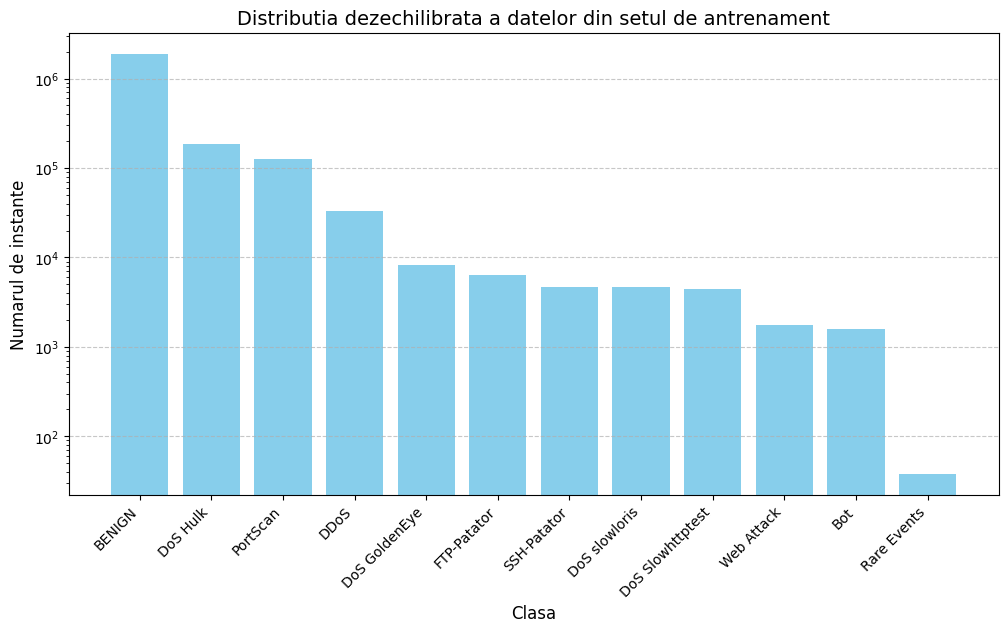

In [9]:
import matplotlib.pyplot as plt

class_distribution = {
    'BENIGN': 1887431,
    'DoS Hulk': 184858,
    'PortScan': 127144,
    'DDoS': 33468,
    'DoS GoldenEye': 8234,
    'FTP-Patator': 6350,
    'SSH-Patator': 4718,
    'DoS slowloris': 4637,
    'DoS Slowhttptest': 4399,
    'Web Attack': 1744,
    'Bot': 1573,
    'Rare Events': 38
}

# Sortare clase pentru vizualizare mai clară
sorted_classes = dict(sorted(class_distribution.items(), key=lambda item: item[1], reverse=True))

# Creare grafic
plt.figure(figsize=(12, 6))
plt.bar(sorted_classes.keys(), sorted_classes.values(), color='skyblue')

# Scală logaritmică pentru a evidenția dezechilibrul extrem
plt.yscale('log')

# Etichetare și stilizare
plt.xticks(rotation=45, ha='right')
plt.xlabel('Clasa', fontsize=12)
plt.ylabel('Numarul de instante', fontsize=12)
plt.title('Distributia dezechilibrata a datelor din setul de antrenament', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afișare grafic
plt.show()


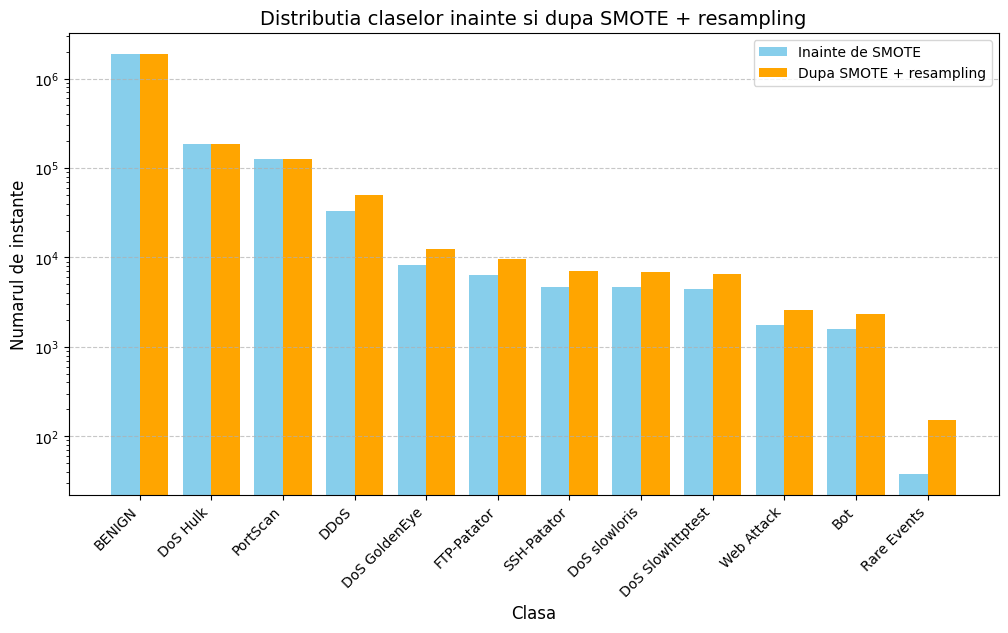

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Distribuția claselor înainte de SMOTE
class_distribution_before = {
    'BENIGN': 1887431,
    'DoS Hulk': 184858,
    'PortScan': 127144,
    'DDoS': 33468,
    'DoS GoldenEye': 8234,
    'FTP-Patator': 6350,
    'SSH-Patator': 4718,
    'DoS slowloris': 4637,
    'DoS Slowhttptest': 4399,
    'Web Attack': 1744,
    'Bot': 1573,
    'Rare Events': 38
}

# Distribuția claselor după SMOTE și resampling
class_distribution_after = {
    'BENIGN': 1887431,
    'DoS Hulk': 184858,
    'PortScan': 127144,
    'DDoS': 50202,
    'DoS GoldenEye': 12351,
    'FTP-Patator': 9525,
    'SSH-Patator': 7077,
    'DoS slowloris': 6955,
    'DoS Slowhttptest': 6598,
    'Web Attack': 2616,
    'Bot': 2359,
    'Rare Events': 152
}

# Sortăm clasele pentru o afișare mai clară
sorted_classes = sorted(class_distribution_before.keys(), key=lambda x: class_distribution_before[x], reverse=True)

# Creăm un array pentru pozițiile pe axa X
x = np.arange(len(sorted_classes))

# Creare grafic
plt.figure(figsize=(12, 6))

# Bare pentru distribuția înainte de SMOTE (albastru)
plt.bar(x - 0.2, [class_distribution_before[label] for label in sorted_classes], width=0.4, label="Inainte de SMOTE", color='skyblue')

# Bare pentru distribuția după SMOTE + resampling (portocaliu)
plt.bar(x + 0.2, [class_distribution_after[label] for label in sorted_classes], width=0.4, label="Dupa SMOTE + resampling", color='orange')

# Scală logaritmică pentru evidențierea dezechilibrului
plt.yscale('log')

# Etichetare și stilizare
plt.xticks(x, sorted_classes, rotation=45, ha='right')
plt.xlabel('Clasa', fontsize=12)
plt.ylabel('Numarul de instante', fontsize=12)
plt.title('Distributia claselor inainte si dupa SMOTE + resampling', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afișare grafic
plt.show()


In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-5)


optimized_model = create_optimized_model(input_shape=X_train_scaled.shape[1], num_classes=y_train_categorical.shape[1])
history_optimized = optimized_model.fit(
    X_train_scaled, y_train_categorical,
    validation_data=(X_test_scaled, y_test_categorical),
    epochs=30, 
    batch_size=128, 
    verbose=2,
    callbacks=[lr_scheduler]
)